### AutoML Model-Building
- Objectives: 
    - This notebook builds an autoML pipeline to predict Indian rice yields

#### Import modules and process data

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import pycaret
from pycaret.regression import *

In [2]:
# Read yield and NDVI/weather data 
processed_weather_yield_df = pd.read_excel('C:\\Users\\djava\\OneDrive\\Documents\\Oxford\\Projects\\india_rice_early_warning\\4_data\\PROCESSED_DATA\\ANALYSIS_READY\\india_yield_weather_ndvi.xlsx')

In [3]:
# filter out data that is 2021 using query
processed_weather_yield_df = processed_weather_yield_df.query('year != 2021')

In [4]:
# Sort data by year ascending for train test split
processed_weather_yield_df = processed_weather_yield_df.sort_values(by='year', ascending=True).copy()

In [5]:
# Drop District, State, Season, Area_ha, Production_t
processed_weather_yield_df.drop(['District', 'State', 'Season', 'Area_ha', 'Production_t'], axis=1, inplace=True)

In [9]:
# processed_weather_yield_df

In [7]:
# Split data into train and test set
train = processed_weather_yield_df.query('year < 2019')
test  = processed_weather_yield_df.query('year >= 2019')

# Print shape of train and test set
print('Data for Modeling: ' + str(train.shape))
print('Unseen Data For Predictions: ' + str(test.shape))

Data for Modeling: (4606, 52)
Unseen Data For Predictions: (502, 52)


#### Experiment 1 (including year and GID as features): set up model

In [10]:
# import pycaret regression and initialize setup
s = setup(data = train,
          test_data=test,
        #   fold_strategy = 'timeseries',
          target = 'Yield_t_ha',
          data_split_shuffle = False,
          # group_features = ['GID_2'],
          session_id = 123,
        #   transformation=True,
        #   normalize=True,
        #   ignore_features = ['year', 'GID_2'],
        #   log_experiment=True,
        #   experiment_name='no_year_gid2'
          )

,Description,Value
0,Session id,123
1,Target,Yield_t_ha
2,Target type,Regression
3,Original data shape,"(5108, 52)"
4,Transformed data shape,"(5108, 52)"
5,Transformed train set shape,"(4606, 52)"
6,Transformed test set shape,"(502, 52)"
7,Numeric features,50
8,Categorical features,1
9,Rows with missing values,5.8%


#### Experiment 1 (including year and GID as features): train and visualize results

In [12]:
# Compare top3 models
best = compare_models(exclude="et", cross_validation=False, sort='MAPE', n_select=3)
# n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3104,0.1679,0.4097,0.8042,0.1290,0.1636,2.7100
catboost,CatBoost Regressor,0.2947,0.1526,0.3907,0.8220,0.1262,0.1784,4.3800
lightgbm,Light Gradient Boosting Machine,0.3119,0.1729,0.4158,0.7984,0.1328,0.1820,0.3200
xgboost,Extreme Gradient Boosting,0.3264,0.1849,0.4300,0.7843,0.1361,0.1915,0.4000
gbr,Gradient Boosting Regressor,0.3077,0.1634,0.4043,0.8094,0.1353,0.2027,7.6200
dt,Decision Tree Regressor,0.4195,0.3349,0.5787,0.6095,0.1849,0.2102,0.2000
ridge,Ridge Regression,0.3498,0.2160,0.4647,0.7481,0.1534,0.2253,0.0500
br,Bayesian Ridge,0.3499,0.2161,0.4649,0.7480,0.1535,0.2256,0.0800
lr,Linear Regression,0.3529,0.2193,0.4683,0.7443,0.1552,0.2293,0.0700
ada,AdaBoost Regressor,0.4473,0.2956,0.5437,0.6553,0.1733,0.2659,1.2800


In [103]:
# # Table with model results
# top3 = pull()

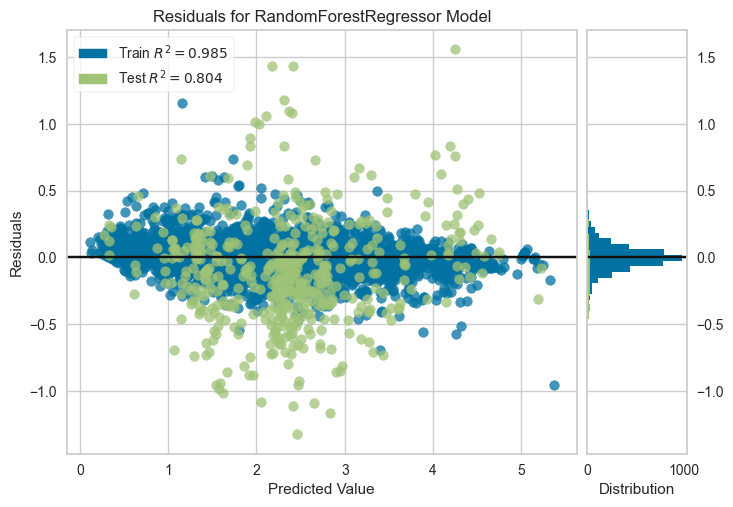

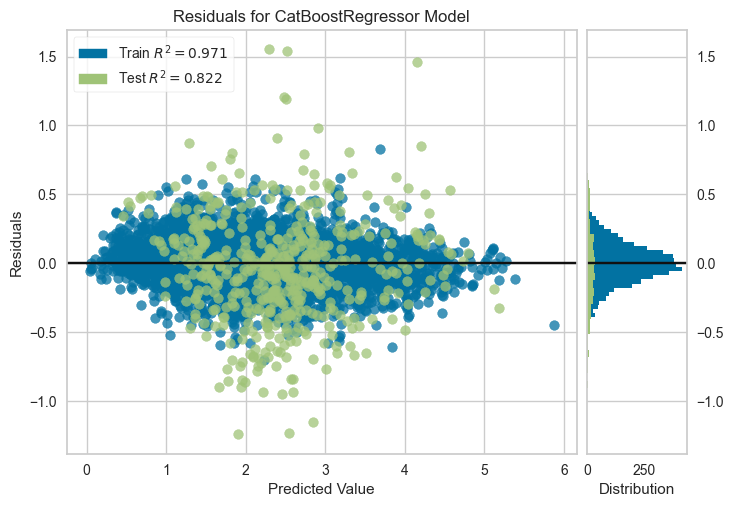

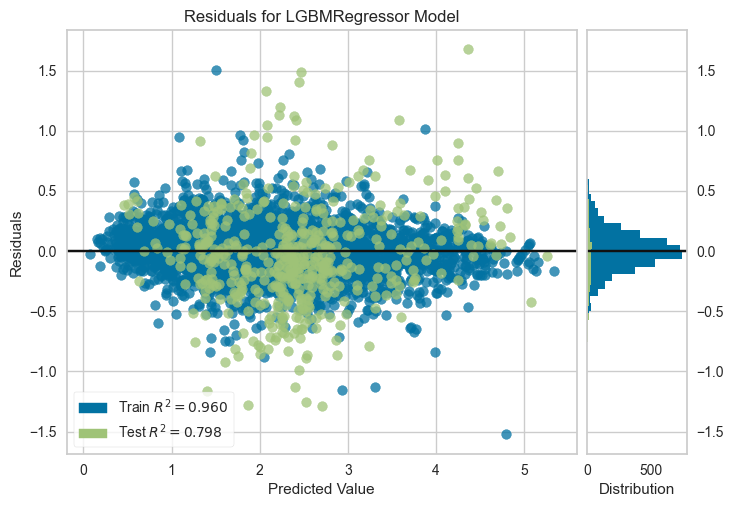

In [13]:
#PLot residuas of top 3 models for each of the models
for model in best:
    plot_model(model, plot = 'residuals')

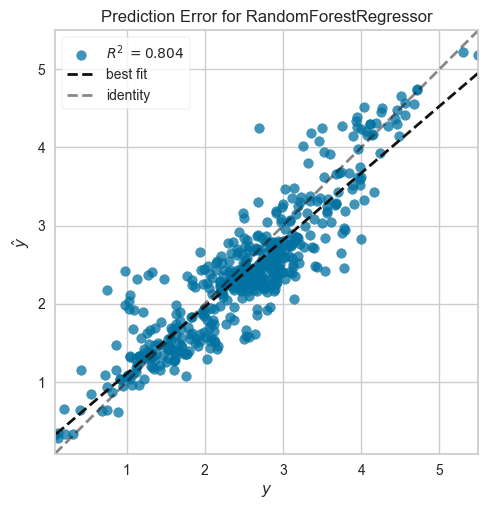

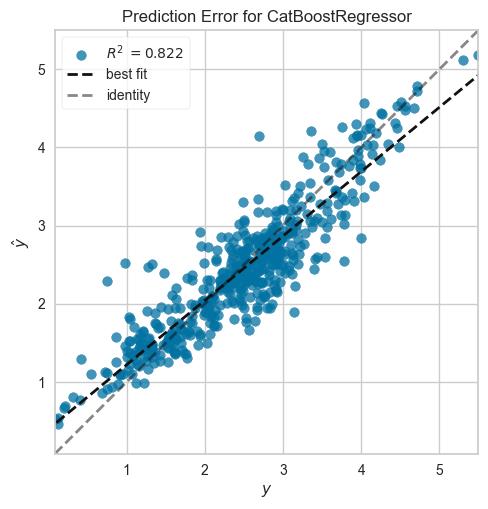

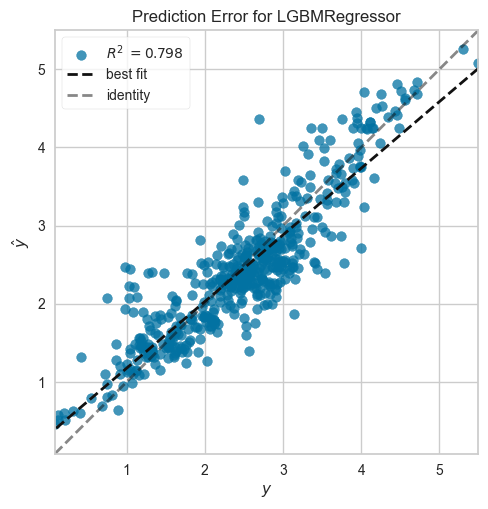

In [14]:
# PLot prediction error of top 3 models for each of the models in the list
for model in best:
    plot_model(model, plot = 'error')

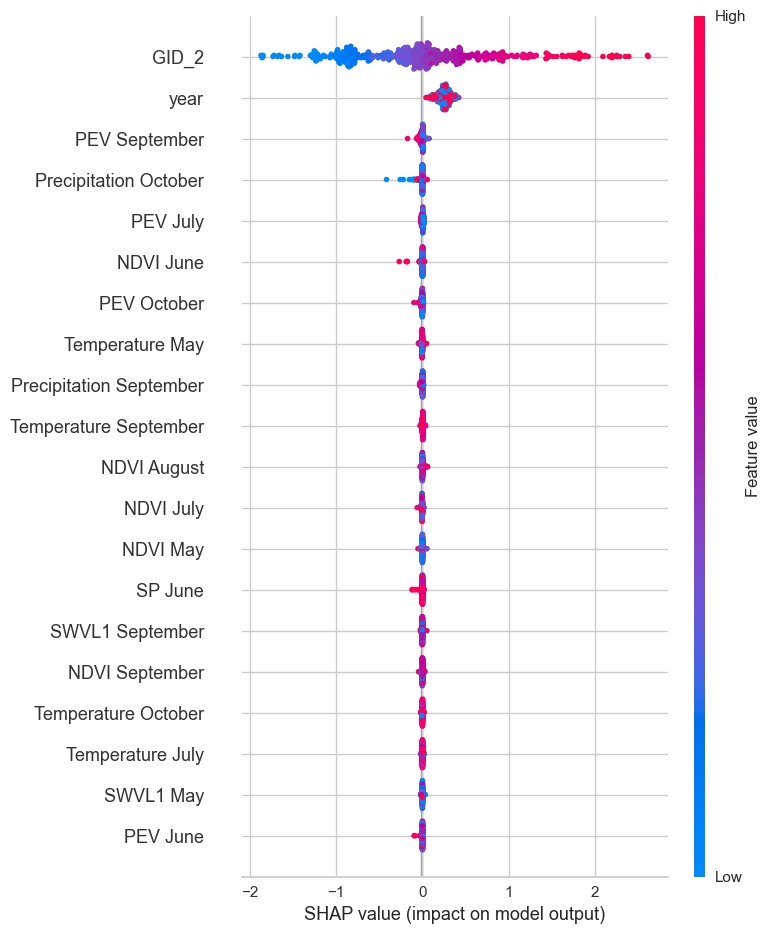

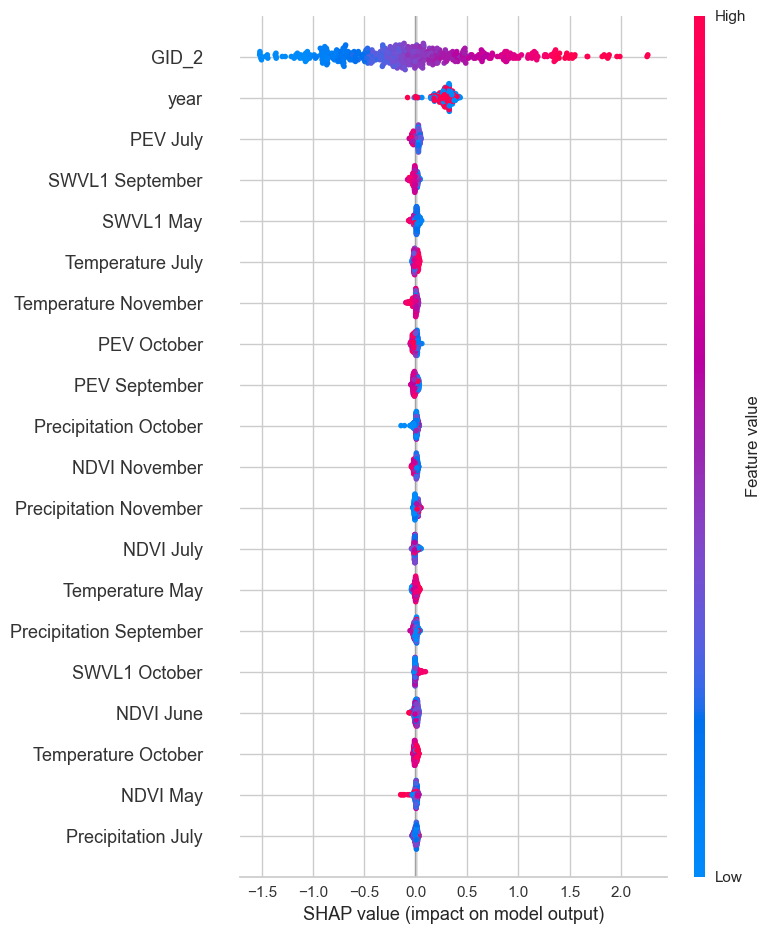

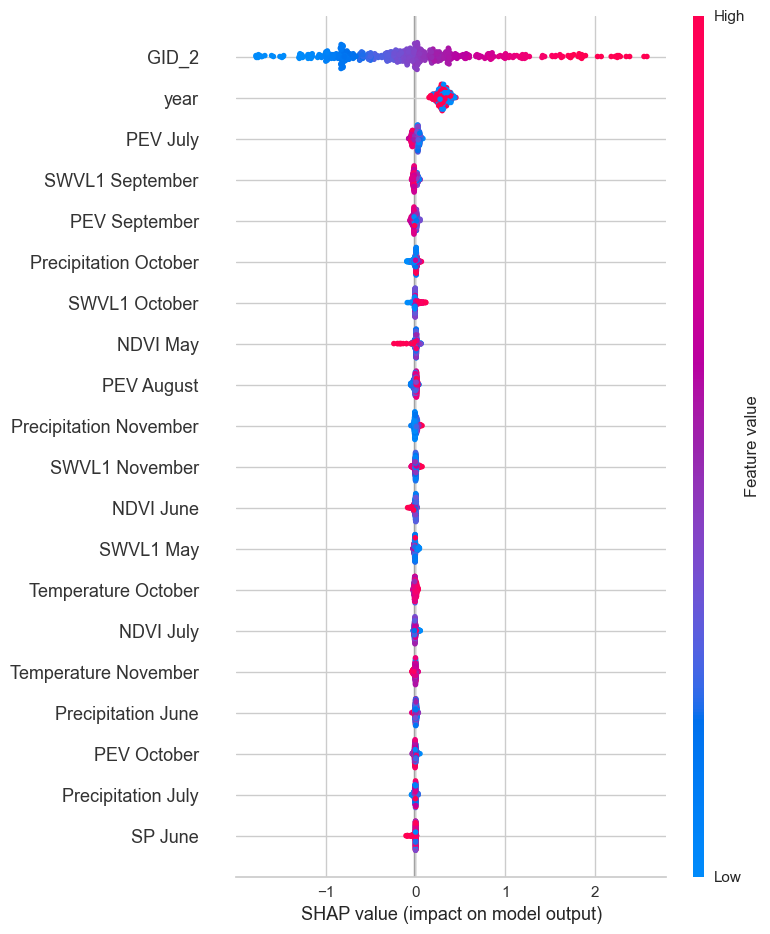

In [15]:
for model in best:
    interpret_model(model, plot = 'summary')

#### Experiment 2 (excluding GID): set up model

In [18]:
# import pycaret regression and initialize setup
s = setup(data = train,
          test_data=test,
        #   fold_strategy = 'timeseries',
          target = 'Yield_t_ha',
          data_split_shuffle = False,
          # group_features = ['GID_2'],
          session_id = 123,
        #   transformation=True,
        #   normalize=True,
          ignore_features = ['year', 'GID_2'],
        #   log_experiment=True,
        #   experiment_name='no_year_gid2'
          )

,Description,Value
0,Session id,123
1,Target,Yield_t_ha
2,Target type,Regression
3,Original data shape,"(5108, 52)"
4,Transformed data shape,"(5108, 50)"
5,Transformed train set shape,"(4606, 50)"
6,Transformed test set shape,"(502, 50)"
7,Ignore features,2
8,Numeric features,49
9,Rows with missing values,5.8%


In [27]:
# Compare top3 models
best = compare_models(exclude="et", cross_validation=False, sort='R2', n_select=3)
# n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4271,0.2843,0.5332,0.6685,0.1711,0.2374,3.7200
lightgbm,Light Gradient Boosting Machine,0.4427,0.3129,0.5594,0.6351,0.1788,0.2455,0.1200
rf,Random Forest Regressor,0.4462,0.3166,0.5627,0.6308,0.1763,0.2463,2.6900
xgboost,Extreme Gradient Boosting,0.4421,0.3364,0.5800,0.6077,0.1845,0.2341,0.3100
gbr,Gradient Boosting Regressor,0.5005,0.3829,0.6188,0.5535,0.1961,0.2832,6.7100
knn,K Neighbors Regressor,0.5473,0.4839,0.6956,0.4357,0.2101,0.3054,0.0200
ada,AdaBoost Regressor,0.6274,0.5677,0.7535,0.3379,0.2395,0.4043,1.1700
ridge,Ridge Regression,0.6147,0.6043,0.7774,0.2953,0.2462,0.3726,0.0200
lr,Linear Regression,0.6122,0.6071,0.7792,0.2920,0.2465,0.3595,0.0300
dt,Decision Tree Regressor,0.5825,0.6507,0.8067,0.2411,0.2711,0.3251,0.1400


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

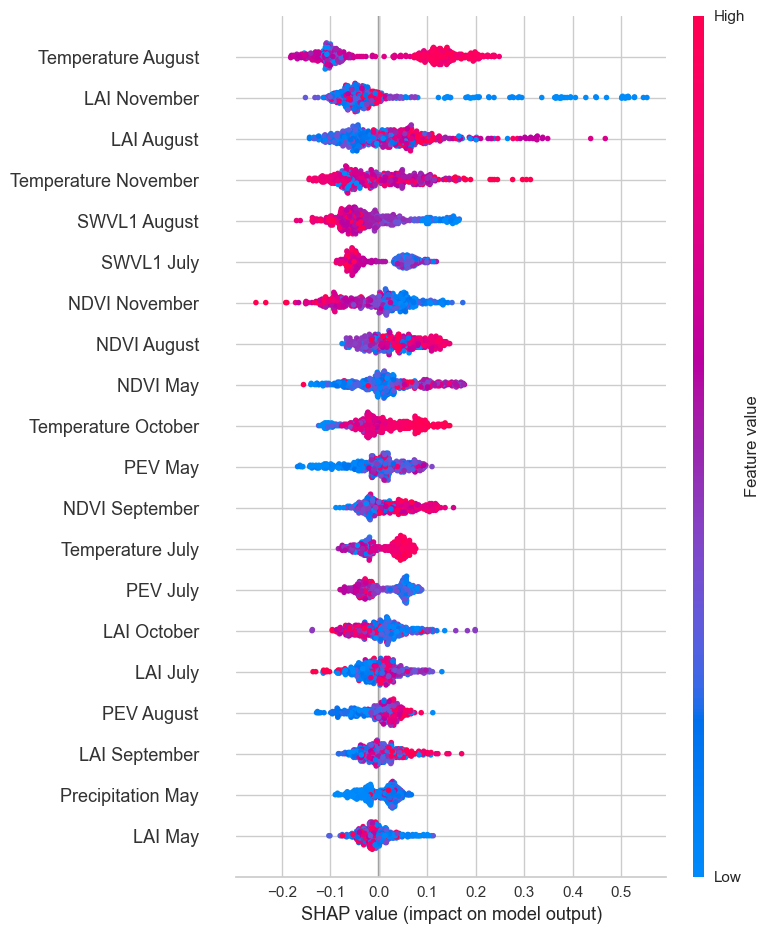

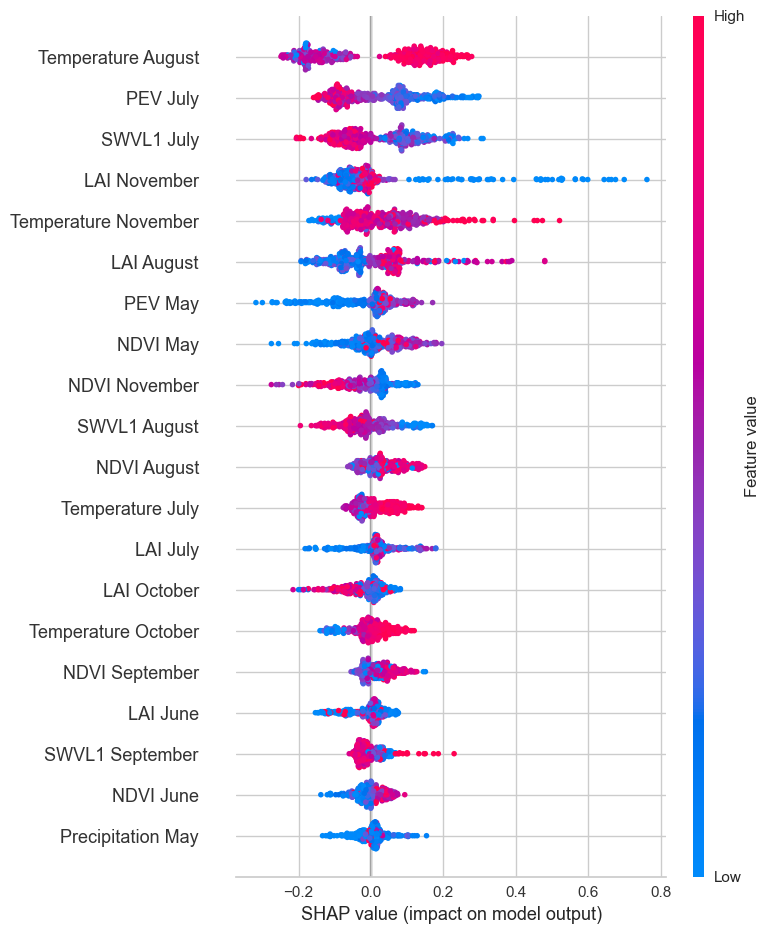

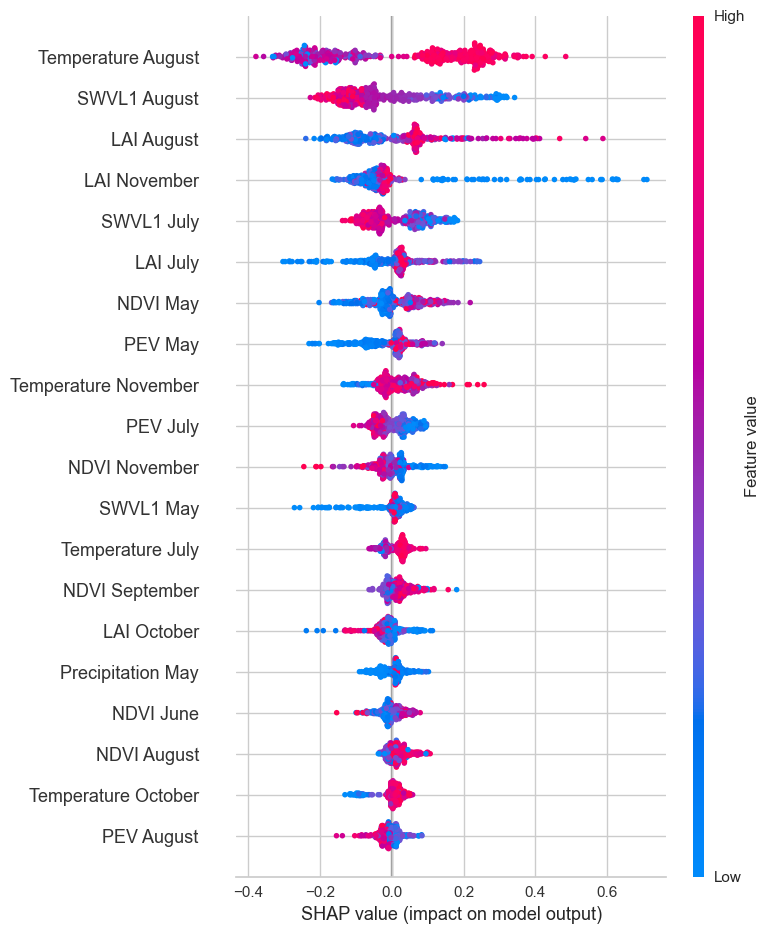

In [28]:
for model in best:
    interpret_model(model, plot = 'summary')

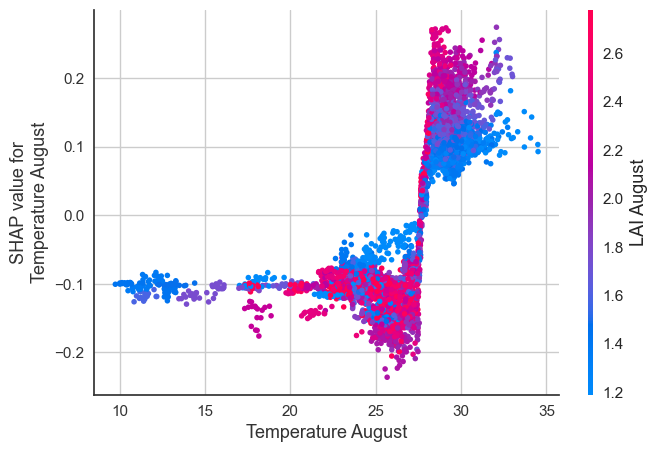

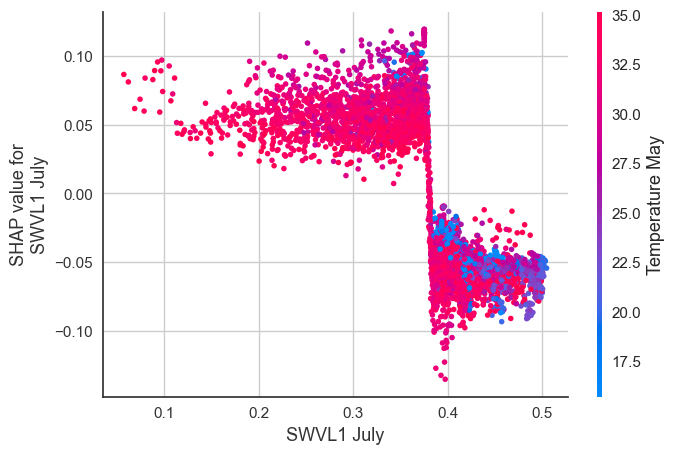

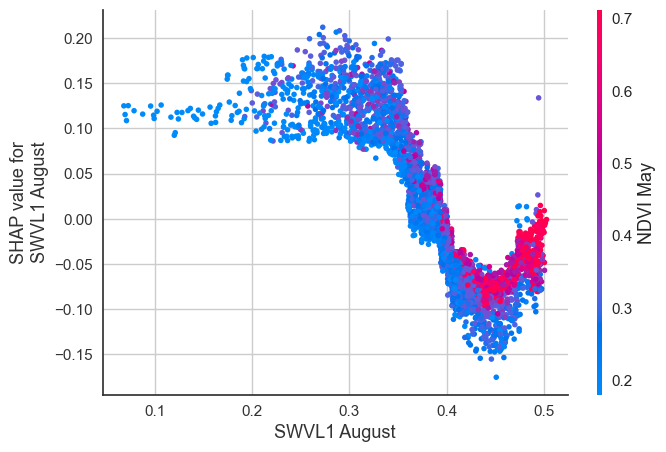

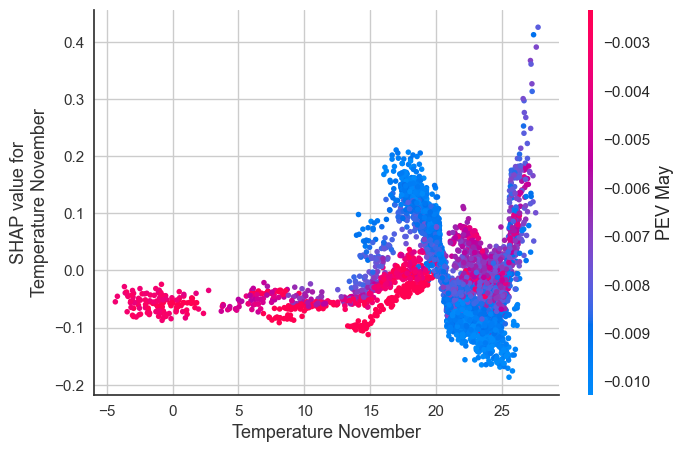

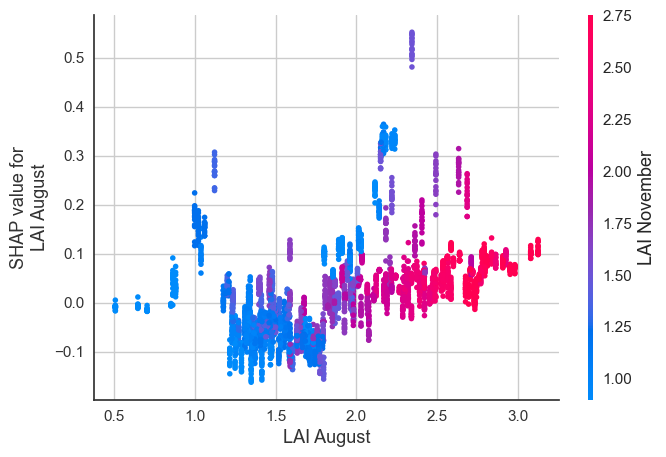

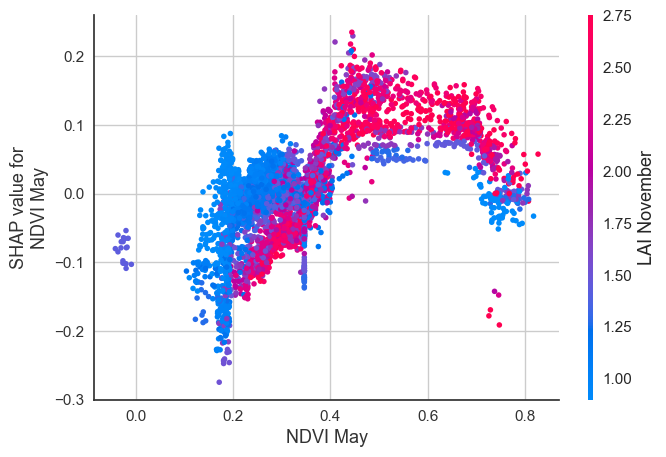

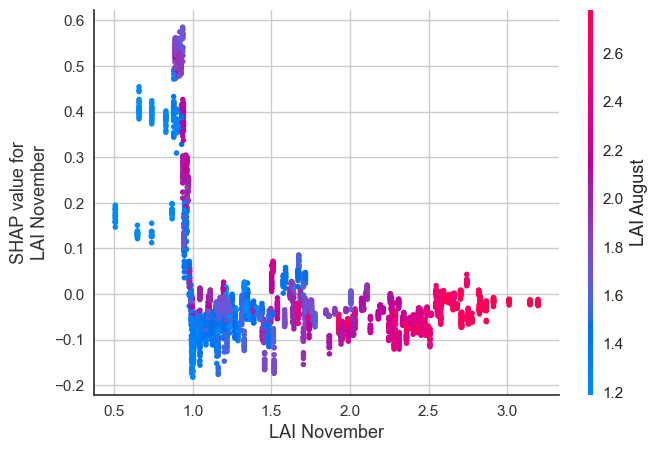

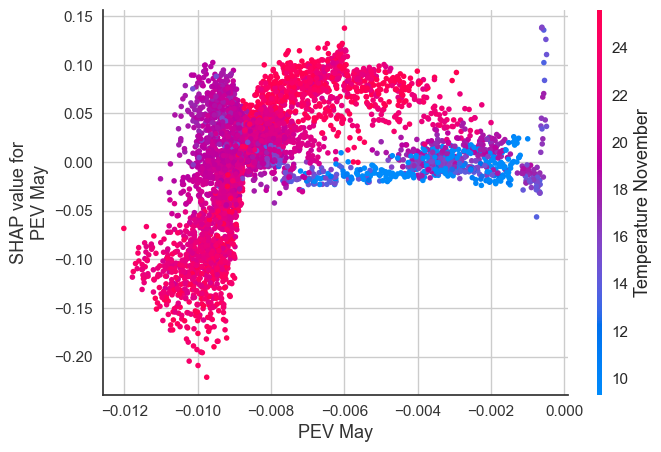

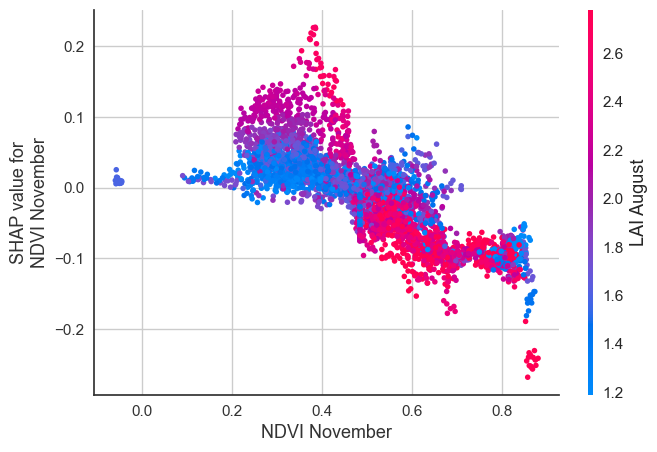

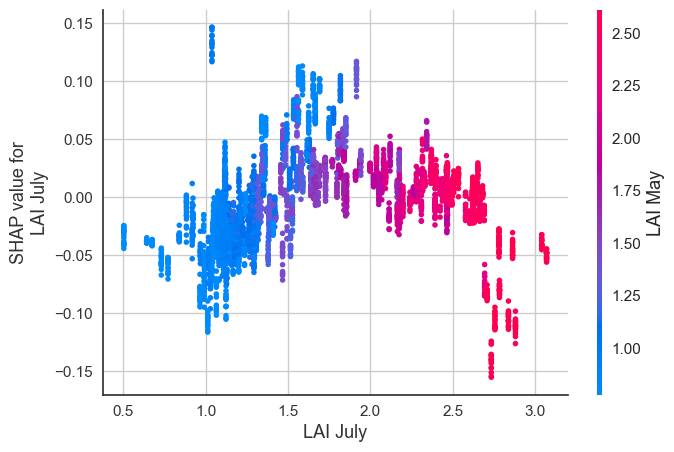

In [31]:
# build list of features to interpret
features = ['Temperature August', 'SWVL1 July', 'SWVL1 August', 'Temperature November', 'LAI August', 'NDVI May', 'LAI November', 'PEV May', 'NDVI November', 'LAI July']

# PLot prediction error of top 3 models for each of the models in the list
for feature in features:
    interpret_model(best[0], plot = 'correlation', feature= feature, use_train_data=True)

In [ ]:
# build list of features to interpret
features = ['Temperature August', 'SWVL1 July', 'SWVL1 August', 'Temperature November', 'LAI August', 'NDVI May']

# For each feature in the list, interpret the model
for feature in features:
    interpret_model(model, plot = 'correlation', feature= feature, title=feature, use_train_data=True)
# interpret_model(best, plot = 'correlation', feature= 'Temperature August', use_train_data=False)

In [209]:
# build list of features to interpret
features = ['Temperature August', 'SWVL1 July', 'SWVL1 August', 'Temperature November', 'LAI August', 'NDVI May']

# For each feature in the list, interpret the model
for feature in features:
    interpret_model(model, plot = 'correlation', feature= feature, title=feature, use_train_data=True)
# interpret_model(best, plot = 'correlation', feature= 'Temperature August', use_train_data=False)

In [137]:
# predict on test set
holdout_pred = predict_model(best)

# Predict on train set
train_pred = predict_model(best, data=train)


# Concatenate train and test predictions
all_pred = pd.concat([train_pred, holdout_pred])


# Read yield and NDVI/weather data 
processed_weather_yield_df = pd.read_excel('C:\\Users\\djava\\OneDrive\\Documents\\Oxford\\Projects\\india_rice_early_warning\\4_data\\PROCESSED_DATA\\ANALYSIS_READY\\india_yield_weather_ndvi.xlsx')

# Keep only the GID_2, State, District columns and unique values
gid2 = processed_weather_yield_df[['GID_2', 'State', 'District']].drop_duplicates()

# Join to all pred
all_pred = all_pred.merge(gid2, on='GID_2', how='left')

# Calculate error
all_pred['error'] = all_pred['Yield_t_ha'] - all_pred['prediction_label']

# Calculate absolute error
all_pred['abs_error'] = abs(all_pred['error'])

# Calculate percentage error
all_pred['abs_perc_error'] = (all_pred['abs_error'] / all_pred['Yield_t_ha']) * 100

# Calculate directional percentage error
all_pred['directional_perc_error'] = ((all_pred['prediction_label'] - all_pred['Yield_t_ha']) / all_pred['Yield_t_ha']) * 100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0786,0.0129,0.1135,0.9853,0.0437,0.0550


In [145]:
# Add a column with the previous year's actual yield
all_pred['previous_year_yield'] = all_pred.groupby(['GID_2'])['Yield_t_ha'].shift(1)

In [149]:
# Calculate the percentage difference between prediction label and previous year yield
all_pred['perc_diff_pred_previous_year'] = ((all_pred['prediction_label'] - all_pred['previous_year_yield']) / all_pred['previous_year_yield']) * 100

In [151]:
all_pred

,GID_2,year,LAI May,LAI June,LAI July,LAI August,LAI September,LAI October,LAI November,PEV May,...,Yield_t_ha,prediction_label,State,District,error,abs_error,abs_perc_error,directional_perc_error,previous_year_yield,perc_diff_pred_previous_year
0,IND.11.12_1,2001,1.290048,1.271173,1.315774,1.476804,1.652562,1.536853,1.388325,-0.008614,...,2.250000,1.968306,Gujarat,Gandhinagar,0.281694,0.281694,12.519749,-12.519749,NaN,NaN
1,IND.3.7_1,2001,2.799932,2.780837,2.782240,2.803077,2.835215,2.856474,2.849742,-0.003740,...,0.974964,1.109280,Arunachal Pradesh,Lohit,-0.134316,0.134316,13.776467,13.776467,NaN,NaN
2,IND.12.7_1,2001,0.775499,0.870030,1.065542,1.288204,1.233746,0.989646,0.898060,-0.008782,...,1.515335,1.608148,Haryana,Jhajjar,-0.092813,0.092813,6.124923,6.124923,NaN,NaN
3,IND.30.3_1,2001,2.135232,2.065446,2.084140,2.142746,2.235734,2.271919,2.193538,-0.002970,...,1.429167,1.435500,Sikkim,South Sikkim,-0.006334,0.006334,0.443178,0.443178,NaN,NaN
4,IND.33.1_1,2001,2.177218,2.172289,2.176767,2.182929,2.202419,2.217656,2.210849,-0.002535,...,1.992542,1.981130,Tripura,Dhalai,0.011413,0.011413,0.572778,-0.572778,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,IND.20.27_1,2020,1.920381,1.935462,1.936285,2.013386,2.185531,2.221187,2.084832,-0.005774,...,1.933797,2.664629,Maharashtra,Raigarh,-0.730832,0.730832,37.792600,37.792600,2.831754,-5.901834
5104,IND.3.12_1,2020,1.857191,1.822158,1.818351,1.864494,1.907071,1.925133,1.904406,-0.002381,...,1.998679,1.882717,Arunachal Pradesh,Papum Pare,0.115962,0.115962,5.801915,-5.801915,1.983136,-5.063647
5105,IND.11.23_1,2020,2.109843,2.110636,2.162858,2.287102,2.386125,2.324105,2.247359,-0.010193,...,1.758799,1.069546,Gujarat,Panch Mahals,0.689254,0.689254,39.188871,-39.188871,1.082997,-1.242011
5106,IND.2.4_1,2020,1.421810,1.470636,1.554391,1.676309,1.841704,2.020102,2.006933,-0.008231,...,3.985336,3.597245,Andhra Pradesh,Guntur,0.388091,0.388091,9.737977,-9.737977,3.963333,-9.236860


In [152]:
# Make error error	abs_error	abs_perc_error	directional_perc_error columns numeric
all_pred['error'] = pd.to_numeric(all_pred['error'])
all_pred['abs_error'] = pd.to_numeric(all_pred['abs_error'])
all_pred['abs_perc_error'] = pd.to_numeric(all_pred['abs_perc_error'])
all_pred['directional_perc_error'] = pd.to_numeric(all_pred['directional_perc_error'])
all_pred['perc_diff_pred_previous_year'] = pd.to_numeric(all_pred['perc_diff_pred_previous_year'])

In [153]:
# Save in folder C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\OUTPUT_DATA\
all_pred.to_excel('C:\\Users\\djava\\OneDrive\\Documents\\Oxford\\Projects\\india_rice_early_warning\\4_data\\OUTPUT_DATA\\pycaret_predictions.xlsx', index=False)

In [142]:
all_pred

,GID_2,year,LAI May,LAI June,LAI July,LAI August,LAI September,LAI October,LAI November,PEV May,...,NDVI October,NDVI November,Yield_t_ha,prediction_label,State,District,error,abs_error,abs_perc_error,directional_perc_error
0,IND.11.12_1,2001,1.290048,1.271173,1.315774,1.476804,1.652562,1.536853,1.388325,-0.008614,...,0.473015,0.401144,2.250000,1.968306,Gujarat,Gandhinagar,0.281694,0.281694,12.519749,-12.519749
1,IND.3.7_1,2001,2.799932,2.780837,2.782240,2.803077,2.835215,2.856474,2.849742,-0.003740,...,0.640776,0.640321,0.974964,1.109280,Arunachal Pradesh,Lohit,-0.134316,0.134316,13.776467,13.776467
2,IND.12.7_1,2001,0.775499,0.870030,1.065542,1.288204,1.233746,0.989646,0.898060,-0.008782,...,0.276104,0.234665,1.515335,1.608148,Haryana,Jhajjar,-0.092813,0.092813,6.124923,6.124923
3,IND.30.3_1,2001,2.135232,2.065446,2.084140,2.142746,2.235734,2.271919,2.193538,-0.002970,...,0.794624,0.718623,1.429167,1.435500,Sikkim,South Sikkim,-0.006334,0.006334,0.443178,0.443178
4,IND.33.1_1,2001,2.177218,2.172289,2.176767,2.182929,2.202419,2.217656,2.210849,-0.002535,...,0.842053,0.816963,1.992542,1.981130,Tripura,Dhalai,0.011413,0.011413,0.572778,-0.572778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,IND.20.27_1,2020,1.920381,1.935462,1.936285,2.013386,2.185531,2.221187,2.084832,-0.005774,...,0.776244,0.655734,1.933797,2.664629,Maharashtra,Raigarh,-0.730832,0.730832,37.792600,37.792600
5104,IND.3.12_1,2020,1.857191,1.822158,1.818351,1.864494,1.907071,1.925133,1.904406,-0.002381,...,0.844262,0.809586,1.998679,1.882717,Arunachal Pradesh,Papum Pare,0.115962,0.115962,5.801915,-5.801915
5105,IND.11.23_1,2020,2.109843,2.110636,2.162858,2.287102,2.386125,2.324105,2.247359,-0.010193,...,0.649666,0.563575,1.758799,1.069546,Gujarat,Panch Mahals,0.689254,0.689254,39.188871,-39.188871
5106,IND.2.4_1,2020,1.421810,1.470636,1.554391,1.676309,1.841704,2.020102,2.006933,-0.008231,...,0.689880,0.667639,3.985336,3.597245,Andhra Pradesh,Guntur,0.388091,0.388091,9.737977,-9.737977
